In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit


In [2]:

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5


#optimizer
learning_rate=0.005

#scheduler
patience=6
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=500


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour


In [3]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

In [4]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='boston' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise

sigma_prior=setup.sigma_prior    

size_data=len(train_dataset)
batch_size=int(np.min([size_data/6,500]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

# Predictive model #

In [5]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)



# ELBO

## Average Log Likelihood

In [6]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise)
    return log_proba.mean()

## Kullback-Leibler divergence Parameter Space

In [7]:
#prior on parameters of predictive model
def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)

#kl NNE approximation
def kl(GeN):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    K=KL(theta, theta_prior,k=kNNE,device=device)
    return K


## ELBO ##

In [8]:
#ELBO
def ELBO(x_data, y_data, GeN):
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl(GeN)
    the_ELBO= - Average_LogLikelihood+ (len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [9]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=751, bias=True)
  )
)


# Optimizer

In [10]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [11]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [12]:
KLs=[]
ELBOs=[]
LRs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[]
             }

start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        theta=GeN(1000).detach()
        metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)

        for m,v in metrics.items():
            test_metrics[m].append(v)

stop = timeit.default_timer()
execution_time = stop - start


 37%|███▋      | 185/500 [00:17<00:32,  9.83it/s, ELBO=41.6, KL=236, LogLike=-3.07, lr=0.0025]

Epoch   184: reducing learning rate of group 0 to 2.5000e-03.


 42%|████▏     | 209/500 [00:19<00:28, 10.12it/s, ELBO=38.5, KL=223, LogLike=-2.14, lr=0.00125]

Epoch   208: reducing learning rate of group 0 to 1.2500e-03.


 43%|████▎     | 215/500 [00:20<00:27, 10.26it/s, ELBO=38.6, KL=223, LogLike=-2.13, lr=0.000625]

Epoch   215: reducing learning rate of group 0 to 6.2500e-04.


 45%|████▍     | 223/500 [00:21<00:27, 10.05it/s, ELBO=38.2, KL=221, LogLike=-2.12, lr=0.000313]

Epoch   223: reducing learning rate of group 0 to 3.1250e-04.


 46%|████▌     | 231/500 [00:22<00:25, 10.36it/s, ELBO=38.2, KL=221, LogLike=-2.12, lr=0.000156]

Epoch   231: reducing learning rate of group 0 to 1.5625e-04.


 48%|████▊     | 239/500 [00:22<00:25, 10.39it/s, ELBO=37.6, KL=218, LogLike=-2.1, lr=0.0001]   

Epoch   238: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 500/500 [00:48<00:00, 10.35it/s, ELBO=37.9, KL=219, LogLike=-2.06, lr=0.0001]


# Results on test #

In [13]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics})
results[dataset].update({'time':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

boston
RMSE: (3.7257158756256104, 5.1289896965026855)
LPP: (-1.9737271070480347, 0.0685078576207161)
PICP: 0.9761630296707153
MPIW: 55.092777252197266
time: 48.31236827210523


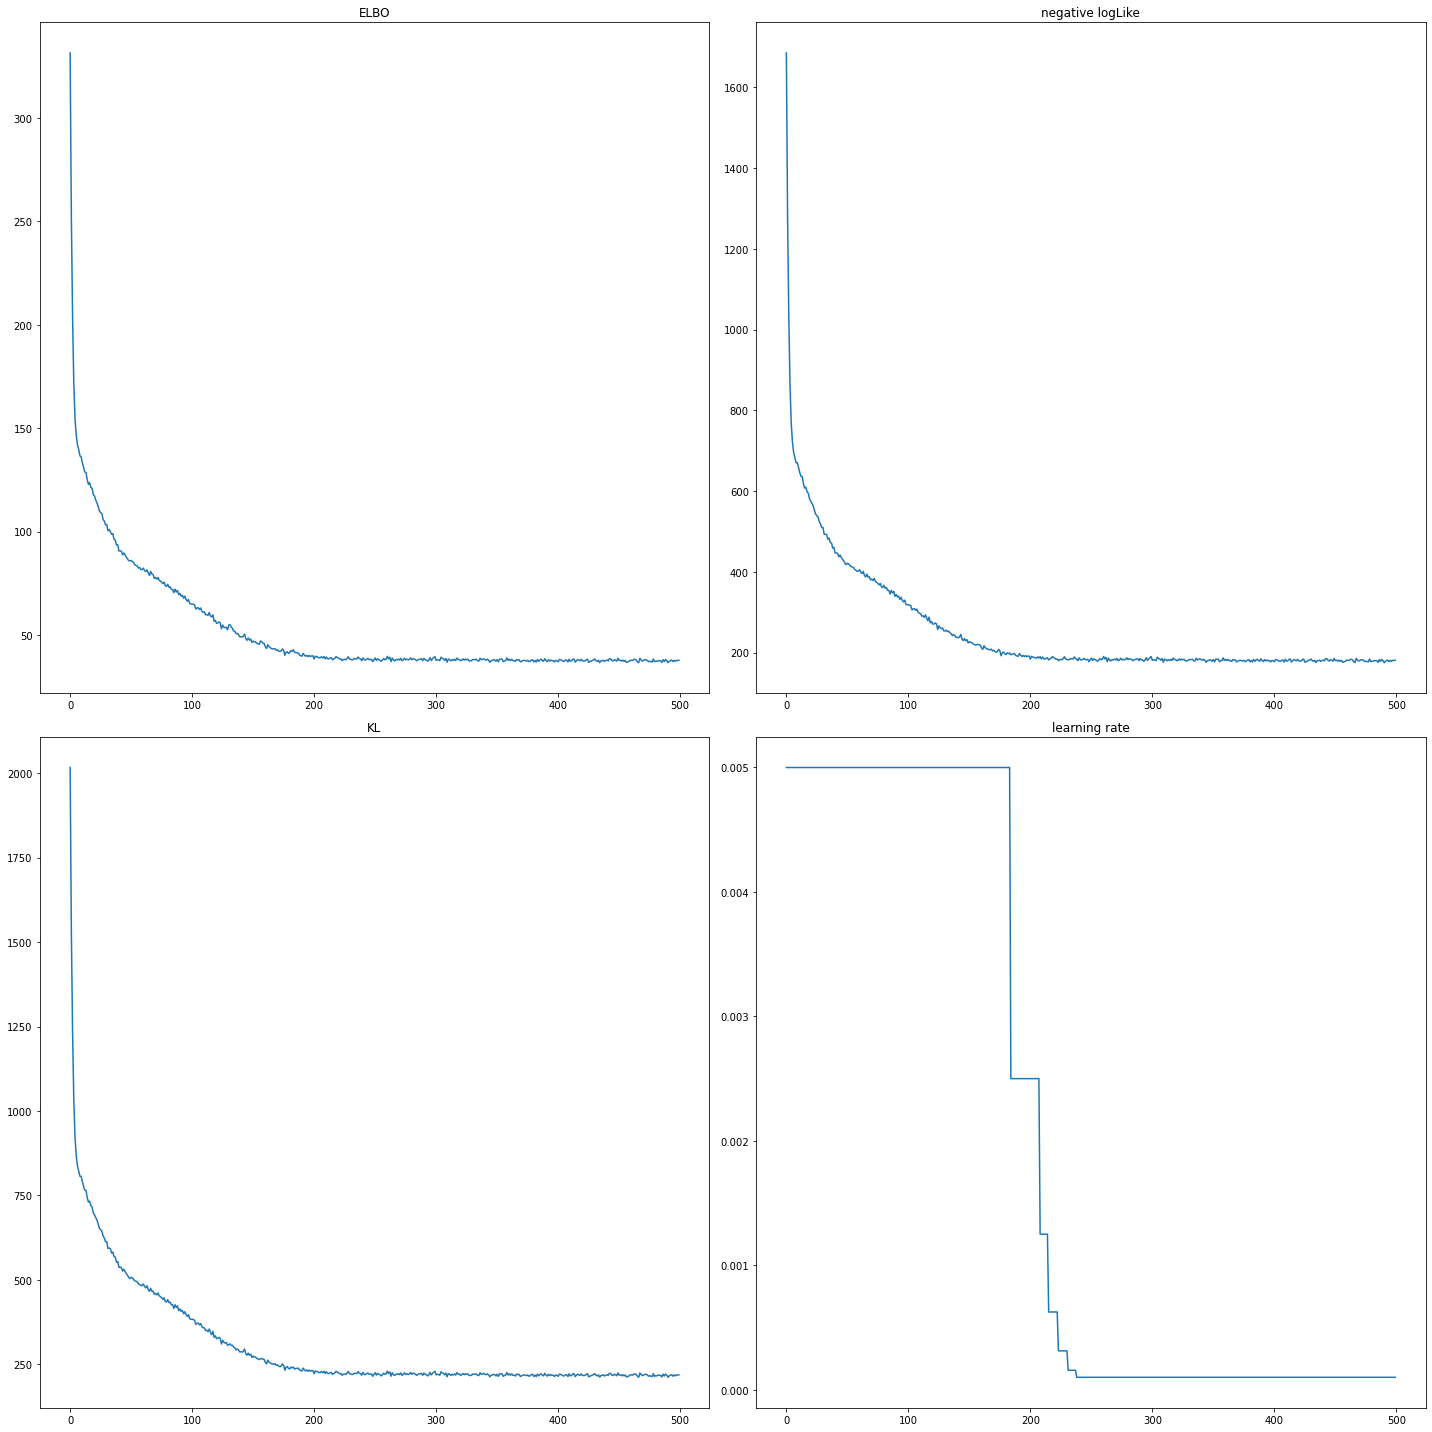

In [14]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs}
ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(torch.arange(0,len(training['KL']),1),ELBO_)
ax[0,0].set_title('ELBO')
ax[0,1].plot(torch.arange(0,len(training['KL']),1),KL_-ELBO_)
ax[0,1].set_title('negative logLike')
ax[1,0].plot(torch.arange(0,len(training['KL']),1),KL_)
ax[1,0].set_title('KL')
ax[1,1].plot(torch.arange(0,len(training['KL']),1),LR_)
ax[1,1].set_title('learning rate')
fig.tight_layout()

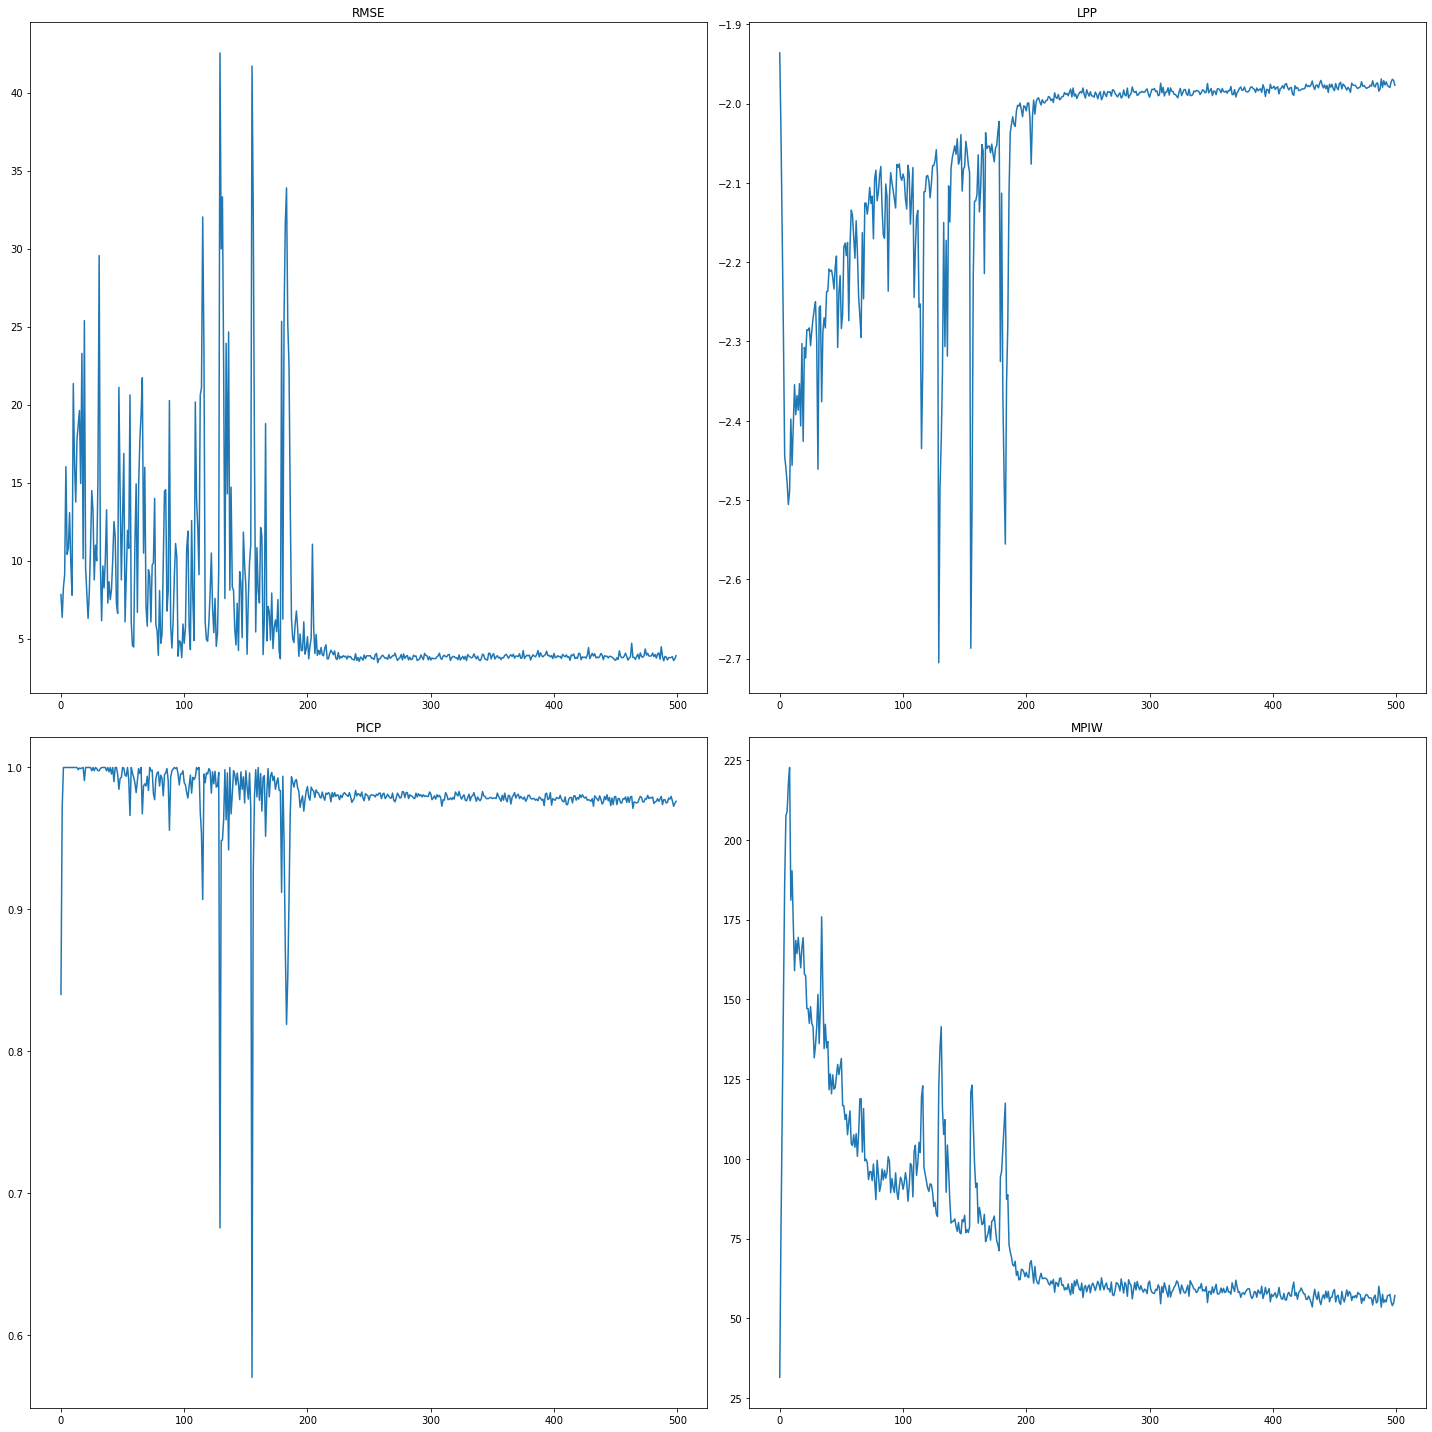

In [15]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,20))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m)
fig.tight_layout()

In [16]:
from Metrics import FunSW, FunKL
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#device='cpu'

def projection(theta0,theta1, n_input_samples):
    #batch sample OOD   
    n_ood=n_input_samples
    epsilon=0.1
    M = x_train.max(0, keepdim=True)[0].to(device)+epsilon
    m = x_train.min(0, keepdim=True)[0].to(device)-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=X_ood

    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2).to(device)
    theta1_proj=model(X, theta1).squeeze(2).to(device)
    return theta0_proj, theta1_proj


def _FunKL(s,t,projection,device):
    k=1
    FKL=FunKL(s,t,projection=projection,device=device,k=k)
    while torch.isinf(FKL):
        k+=1
        FKL=FunKL(s,t,projection=projection,device=device,k=k)
    return FKL

In [17]:
models_HMC = torch.load('Results/HMC_models.pt')
t=models_HMC[dataset].to(device)
s=GeN(t.shape[0]).detach().to(device)
kl_to=_FunKL(s,t,projection,device)
kl_from=_FunKL(t,s,projection,device)
print('KL(-,HMC): '+str(kl_to.item()))
print('KL(HMC,-): '+str(kl_from.item()))

KL(-,HMC): 25.122732162475586
KL(HMC,-): -4.278310775756836
